## Using BERTopic to assign topics to reviews

Using the pre-trained model we then assign a topic to each row. This was very computationally intensive, and process pooling was used to increase efficiency by about 25%. 

We then graphed the most popular topics, and it's difficult to establish meaning.

In [20]:
# Import Libraries
import pandas as pd
import pickle
import numpy as np
from tqdm import tqdm

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# These are to try and speed up processing. my_module is a custom module that I created to help with this.
from concurrent.futures import ProcessPoolExecutor, as_completed
from my_module import assign_topics_to_batch, chunks

import matplotlib.pyplot as plt

In [ ]:
# Load the data
summary_df = pd.read_csv('/Users/paulhershaw/brainstation_course/airplane_project/data/dataframe/summary_df_llm_lda.csv')

In [ ]:
# Load the BERTopic model from topic_model_1.pkl
with open('/Users/paulhershaw/brainstation_course/airplane_project/data/topic_model_1.pkl', 'rb') as model_file:
    topic_model_2 = pickle.load(model_file)

# Load topics and probabilities from topics_probs_2.pkl
with open('/Users/paulhershaw/brainstation_course/airplane_project/data/topics_probs_2.pkl', 'rb') as topics_probs_file:
    topics, probabilities = pickle.load(topics_probs_file)

In [ ]:
# Get the topic information
topic_info = topic_model_2.get_topic_info()(1)

topic_info

In [ ]:
# This function will assign topics to a batch of rows, looking at each customer review individually.
def process_reviews_in_parallel(texts, model_path, batch_size=75):
    text_batches = list(chunks(texts, batch_size))
    
    # Use a process pool executor to parallelize assigning topics to batches of text. 
    # This approach leverages multiprocessing to speed up the processing of large 
    # volumes of text data by distributing the work across multiple processes.
    with ProcessPoolExecutor() as executor:
        futures = [executor.submit(assign_topics_to_batch, batch, model_path) for batch in text_batches]
        
        results = []
        for future in tqdm(as_completed(futures), total=len(futures), desc="Processing Batches"):
            # Directly extend the list with whatever results are obtained
            batch_results = future.result()
            if batch_results is not None:
                results.extend(batch_results)

    return results
# Run the functions. 
if __name__ == "__main__":
    texts = summary_df['customer_review'].tolist()
    model_path = '/Users/paulhershaw/brainstation_course/airplane_project/data/topic_model_1.pkl'
    batch_size = 100 # Adjust based on your system's memory and the model's size

    # Process reviews and assign the results back to the DataFrame
    summary_df['BERTopic'] = process_reviews_in_parallel(texts, model_path, batch_size)


In [ ]:
BERTopic_df = summary_df['BERTopic']

In [ ]:
BERTopic_df.to_csv('/Users/paulhershaw/brainstation_course/airplane_project/data/bert_output.csv', index=False)

In [ ]:
#Load past results
df = pd.read_csv('/Users/paulhershaw/brainstation_course/airplane_project/data/bert_output.csv')

In [17]:
# Count the # of rows each topic was assigned to.
topic_info = topic_model_2.get_topic_info()  
unique_value_counts = df['BERTopic'].value_counts()
unique_value_counts_df = unique_value_counts.reset_index()
unique_value_counts_df.columns = ['Topic', 'Count']
# Assuming topic_info is already defined and has a 'Topic' column
topic_row_count = pd.merge(unique_value_counts_df, topic_info, on='Topic')

In [18]:
# Drop first row. These are basically the "unassigned" topics.
topic_row_count = topic_row_count.drop(0, axis=0)

# DataFrame with the top 20 topics
top_20_topics = topic_row_count.sort_values(by='Count_x', ascending=False).head(20)

In [25]:
top_20_topics

,Topic,Count_x,Count_y,Name,Representation,Representative_Docs
1,0,959,2832,0_china_guangzhou_beijing_southern,"[china, guangzhou, beijing, southern, shanghai...",[shanghai to beijing and air china is not bad ...
2,1,722,2093,1_spirit_you_airlines_pay,"[spirit, you, airlines, pay, lauderdale, for, ...","[worst airline i have been on, and i have trav..."
3,2,510,1622,2_singapore_cathay_kong_hong,"[singapore, cathay, kong, hong, pacific, hkg, ...",[london heathrow to melbourne via hong kong. f...
4,3,431,1316,3_norwegian_sas_copenhagen_oslo,"[norwegian, sas, copenhagen, oslo, stockholm, ...",[ i booked with norwegian but i was on an extr...
5,4,423,1311,4_ryanair_stansted_boarding_you,"[ryanair, stansted, boarding, you, we, to, pri...",[ stansted to hamburg. i booked a flight with ...
6,7,385,1284,7_bangkok_thai_bkk_airways,"[bangkok, thai, bkk, airways, chiang, samui, m...",[flew from melbourne to bangkok on 777-200 the...
7,9,354,991,9_etihad_abu_dhabi_auh,"[etihad, abu, dhabi, auh, airways, was, the, t...",[ abu dhabi to cairo. etihad lost my bag in fe...
8,8,334,1079,8_frontier_denver_they_carry,"[frontier, denver, they, carry, for, to, will,...",[frontier airlines. beware: limited flights sc...
9,10,282,831,10_qantas_sydney_melbourne_brisbane,"[qantas, sydney, melbourne, brisbane, syd, qf,...",[ i was flying with qantas from auckland to si...
10,13,256,776,13_india_delhi_indigo_mumbai,"[india, delhi, indigo, mumbai, air, del, chenn...",[ goa to london via mumbai. we flew air india ...


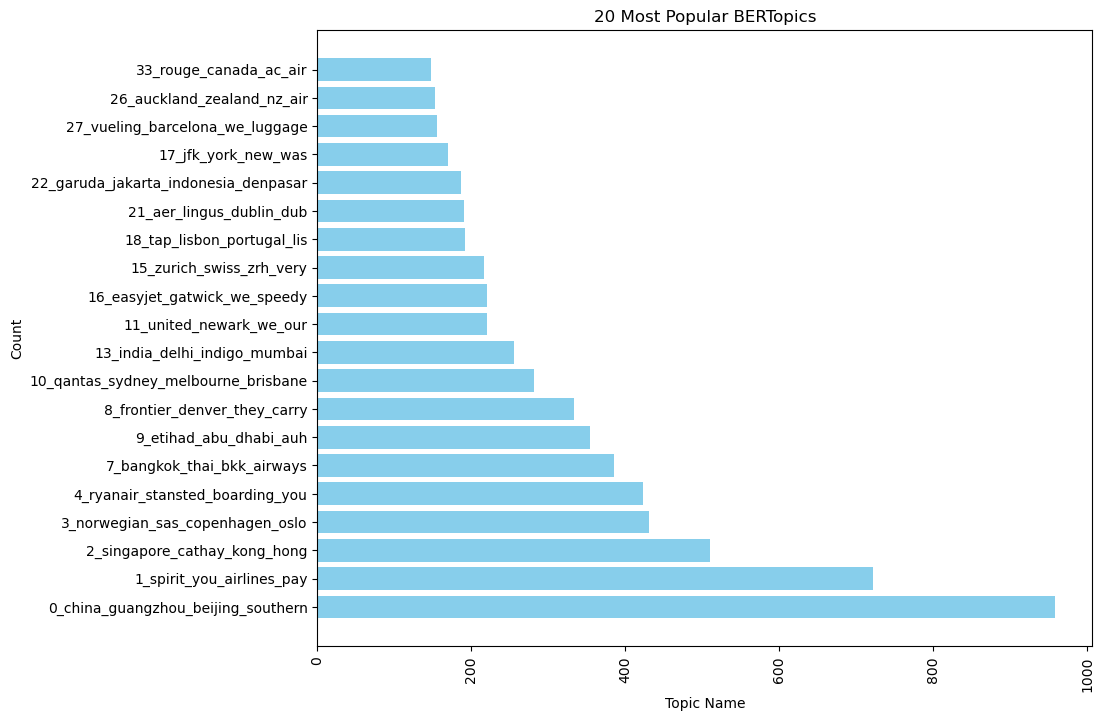

In [27]:


# Graph top 20 most popular BERtopics
plt.figure(figsize=(10, 8))
plt.barh(top_20_topics['Name'], top_20_topics['Count_x'], color='skyblue')
plt.xlabel('Topic Name')
plt.ylabel('Count')
plt.xticks(rotation=90)  # Rotate labels to avoid overlap
plt.title('20 Most Popular BERTopics')
plt.show()


## BERTopics
As you can see, while this is a powerful tool, brining meaning to the topics is difficult. I will need to do more work. 